# Análise Exploratória dos Dados de Prefeitos (2k-200k habitantes)

Este notebook apresenta uma análise exploratória do arquivo `dados_unificados_prefeitos_200k.csv`, que consolida as informações de resultados eleitorais, valores de emendas PIX e indicadores socioeconômicos dos municípios.

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm # estimação de modelos
from scipy import stats # estatística chi2
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from scipy.stats import gaussian_kde # inserção de KDEs em gráficos
from matplotlib.gridspec import GridSpec # plotagem de gráficos separados
import time # definição do intervalo de tempo entre gráficos com animação
import imageio # para geração de figura GIF
from tqdm import tqdm # adiciona um indicador de progresso do código


sns.set(style='whitegrid')
pd.options.display.float_format = '{:.2f}'.format

path = '../data/dados_unificados_prefeitos_200k.csv'
df = pd.read_csv(path)
df.head()

,municipio,sigla_municipio,prefeito_eleito_2024,sigla_partido_prefeito_eleito,porcentagem_votos_validos_2024,emendas_pix_per_capita_partido_prefeito_eleito,idhm_2010,alfabetizacao_2010,pib_per_capita_2021,densidade_demografica_2010
0,ABADIA DE GOIAS - GO,GO,WANDER SARAIVA,PP,1.00,18716.02,0.71,92.19,18491.22,133.40
1,ABADIA DOS DOURADOS - MG,MG,CIRO,PSD,0.58,3188.78,0.69,90.88,28184.63,7.13
2,ABADIANIA - GO,GO,DR ITAMAR,PP,0.62,3481.89,0.69,89.16,25842.85,16.51
3,ABAETE - MG,MG,IVANIR,MDB,0.49,1764.06,0.70,91.28,23869.42,12.48
4,ABAETETUBA - PA,PA,FRANCINETI CARVALHO,MDB,0.42,2528.61,0.63,86.29,12322.94,98.23


## Visão Geral

A primeira etapa consiste em verificar o formato da base e o tipo das variáveis.

### Filtragem de casos sem emendas ou com votação unânime e partidos com menos de 10 candidatos
As análises a seguir desconsideram municípios que receberam soma zero de Emendas PIX e onde apenas um candidato concorreu (100% dos votos válidos).

In [213]:
# # Contar e printar 0s da coluna 'emendas_pix_per_capita_partido_prefeito_eleito'
# zero_count = (df['emendas_pix_per_capita_partido_prefeito_eleito'] == 0).sum()
# print(f'Número de zeros na coluna "emendas_pix_per_capita_partido_prefeito_eleito": {zero_count}')

# # Contar e printar 1s da coluna 'porcentagem_votos_validos_2024'
# one_count = (df['porcentagem_votos_validos_2024'] == 1).sum()
# print(f'Número de uns na coluna "porcentagem_votos_validos_2024": {one_count}')
    

In [214]:
# # Remover 0s da coluna 'emendas_pix_per_capita_partido_prefeito_eleito'
# df = df[df['emendas_pix_per_capita_partido_prefeito_eleito'] > 0]
# # Remover 1s da coluna 'porcentual_votos_partido_prefeito_eleito'
# df = df[df['porcentagem_votos_validos_2024'] < 1]

# # Contar e printar onde a soma de municipios de determinado partido é menor que 10
# parties = df['sigla_partido_prefeito_eleito'].value_counts()
# low_count_parties = parties[parties < 10]
# print("Partidos com menos de 10 municípios:")
# for party, count in low_count_parties.items():
#     print(f'{party}: {count} municípios')
    
# # Remover partidos com menos de 10 municípios
# df = df[df['sigla_partido_prefeito_eleito'].isin(parties[parties >= 10].index)]

# # Remover linhas com valores NaN
# df = df.dropna(subset=['emendas_pix_per_capita_partido_prefeito_eleito', 'porcentagem_votos_validos_2024', 'sigla_partido_prefeito_eleito'])

# # Remover linhas com valores NaN
# df.shape, df.dtypes

In [215]:
# # Remover valores extremos da coluna 'emendas_pix_per_capita_partido_prefeito_eleito'
# def remove_outliers(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# df = remove_outliers(df, 'emendas_pix_per_capita_partido_prefeito_eleito')

In [216]:
# Atribuição de categorias para as variáveis 'prefeito_eleito_2024', 'sigla_partido_prefeito_eleito', 'municipio', and 'sigla_municipio'
df['prefeito_eleito_2024'] = df['prefeito_eleito_2024'].astype('category')
df['sigla_partido_prefeito_eleito'] = df['sigla_partido_prefeito_eleito'].astype('category')
df['municipio'] = df['municipio'].astype('category')
df['sigla_municipio'] = df['sigla_municipio'].astype('category')

df.describe().round(2)

,porcentagem_votos_validos_2024,emendas_pix_per_capita_partido_prefeito_eleito,idhm_2010,alfabetizacao_2010,pib_per_capita_2021,densidade_demografica_2010
count,5208.00,5208.00,5186.00,5186.00,5208.00,5208.00
mean,0.62,7349.93,0.66,83.42,33680.94,68.11
std,0.15,16346.43,0.07,9.84,39217.92,300.17
min,0.23,0.00,0.42,55.60,5698.89,0.15
25%,0.52,0.00,0.60,75.20,13237.41,11.10
50%,0.58,500.72,0.66,86.39,23386.45,23.63
75%,0.69,7828.63,0.71,91.59,40514.77,49.82
max,1.00,386773.03,0.86,99.05,919488.03,10718.67


## Distribuições

As distribuições das variáveis numéricas ajudam a identificar possíveis assimetrias e a presença de outliers.

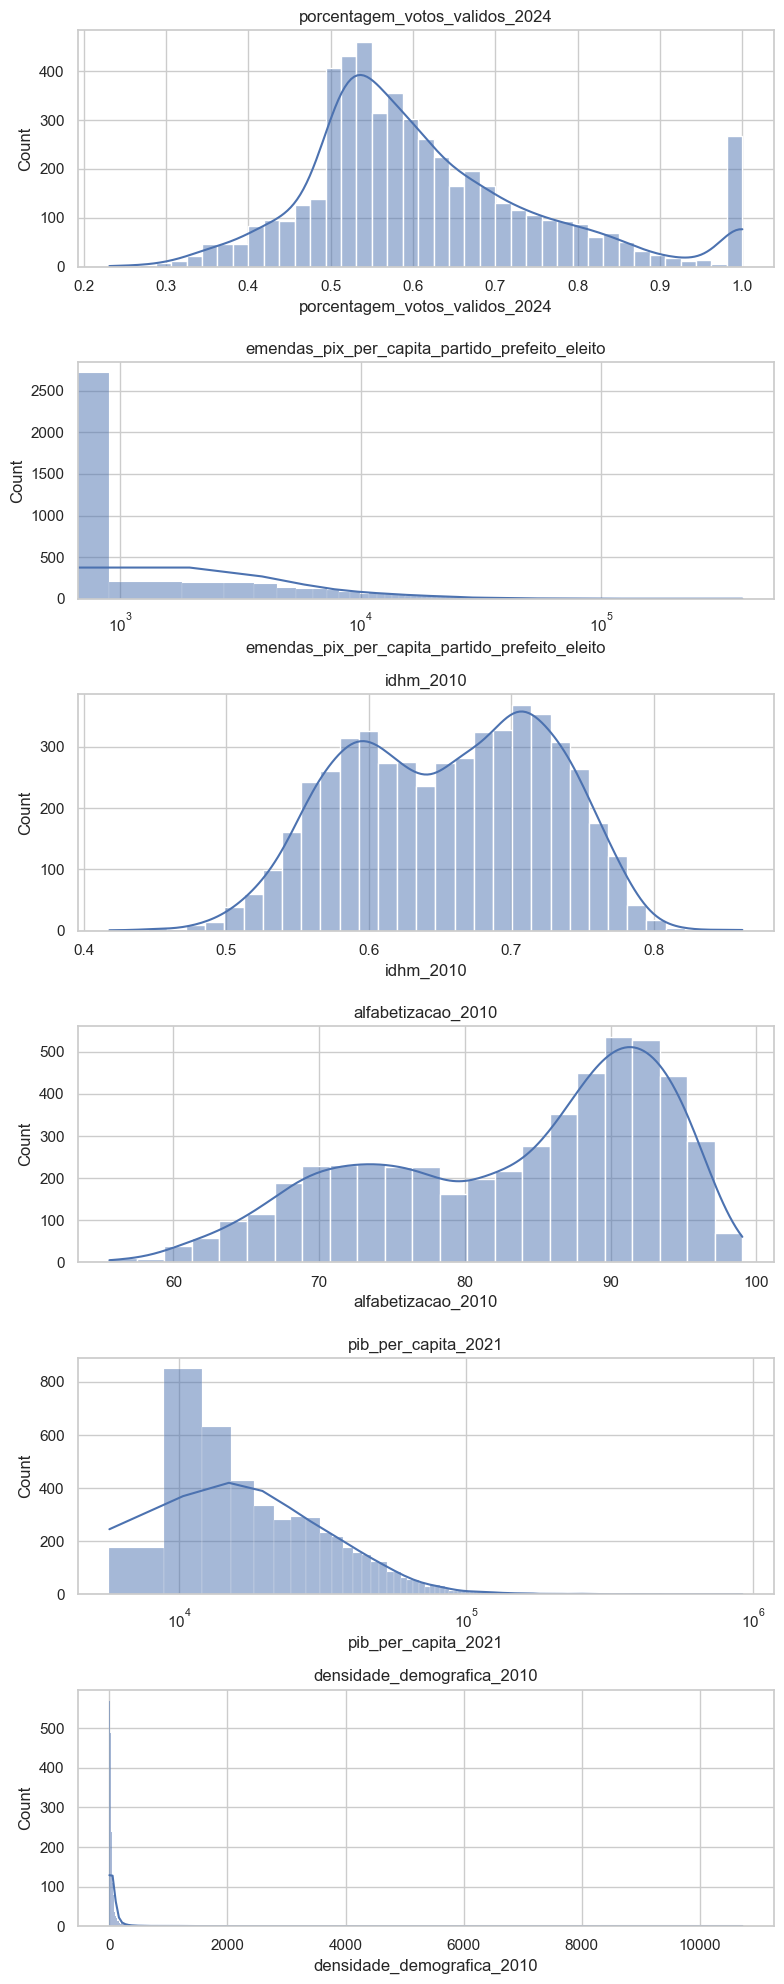

In [217]:
num_cols = ['porcentagem_votos_validos_2024', 'emendas_pix_per_capita_partido_prefeito_eleito',
            'idhm_2010', 'alfabetizacao_2010', 'pib_per_capita_2021', 'densidade_demografica_2010']
# Gera um histograma para cada variável
fig, axes = plt.subplots(len(num_cols), 1, figsize=(8, 20))
for ax, col in zip(axes, num_cols):
    sns.histplot(data=df, x=col, kde=True, ax=ax)
    if col in ['emendas_pix_per_capita_partido_prefeito_eleito', 'pib_per_capita_2021']:
        ax.set_xscale('log')
    ax.set_title(col)
plt.tight_layout()

## Partidos

Analisamos a distribuição das siglas partidárias e o desempenho médio por partido.

In [218]:
party_counts = df['sigla_partido_prefeito_eleito'].value_counts().head(30)
party_counts

sigla_partido_prefeito_eleito
PSD              838
MDB              812
PP               713
UNIÃO            545
PL               467
REPUBLICANOS     409
PSB              302
PSDB             259
PT               240
PDT              139
AVANTE           130
PODE             112
PRD               73
SOLIDARIEDADE     61
CIDADANIA         31
PC do B           19
MOBILIZA          18
NOVO              16
PV                13
REDE               4
AGIR               3
DC                 2
PMB                2
Name: count, dtype: int64

In [219]:
party_perf = df.groupby('sigla_partido_prefeito_eleito')['porcentagem_votos_validos_2024'].mean().sort_values(ascending=False)
party_perf.head(30)

C:\Users\bruno\AppData\Local\Temp\ipykernel_7140\1708904653.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  party_perf = df.groupby('sigla_partido_prefeito_eleito')['porcentagem_votos_validos_2024'].mean().sort_values(ascending=False)


sigla_partido_prefeito_eleito
AGIR            0.84
REDE            0.69
CIDADANIA       0.66
PSB             0.63
PSD             0.63
MOBILIZA        0.63
MDB             0.63
PC do B         0.62
UNIÃO           0.62
PRD             0.62
REPUBLICANOS    0.62
AVANTE          0.62
PP              0.61
PDT             0.60
PSDB            0.60
PT              0.60
PODE            0.59
PL              0.59
SOLIDARIEDADE   0.58
PV              0.55
NOVO            0.54
PMB             0.53
DC              0.50
Name: porcentagem_votos_validos_2024, dtype: float64

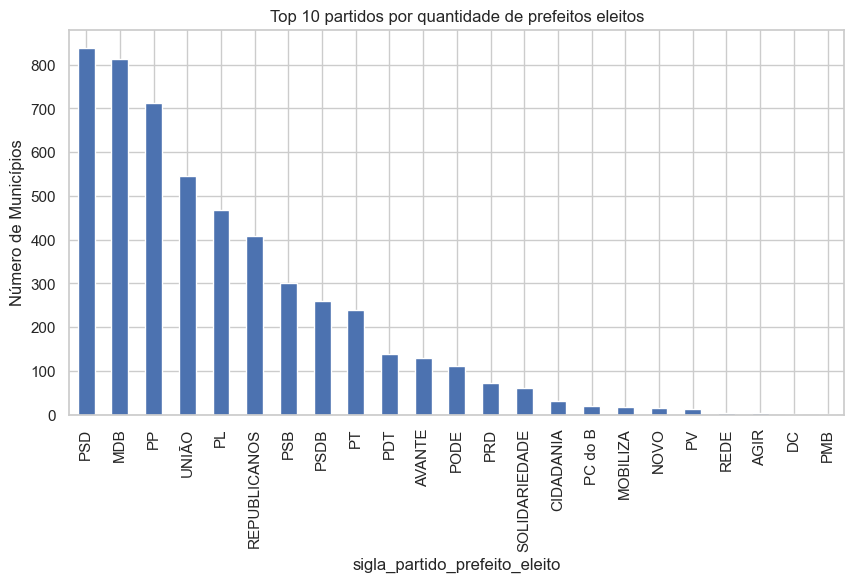

In [220]:
fig, ax = plt.subplots(figsize=(10,5))
party_counts.plot(kind='bar', ax=ax)
ax.set_ylabel('Número de Municípios')
ax.set_title('Top 10 partidos por quantidade de prefeitos eleitos')
plt.show()


## Pairplot das Variáveis Numéricas

Visualização conjunta das principais variáveis numéricas para identificar relações e padrões.

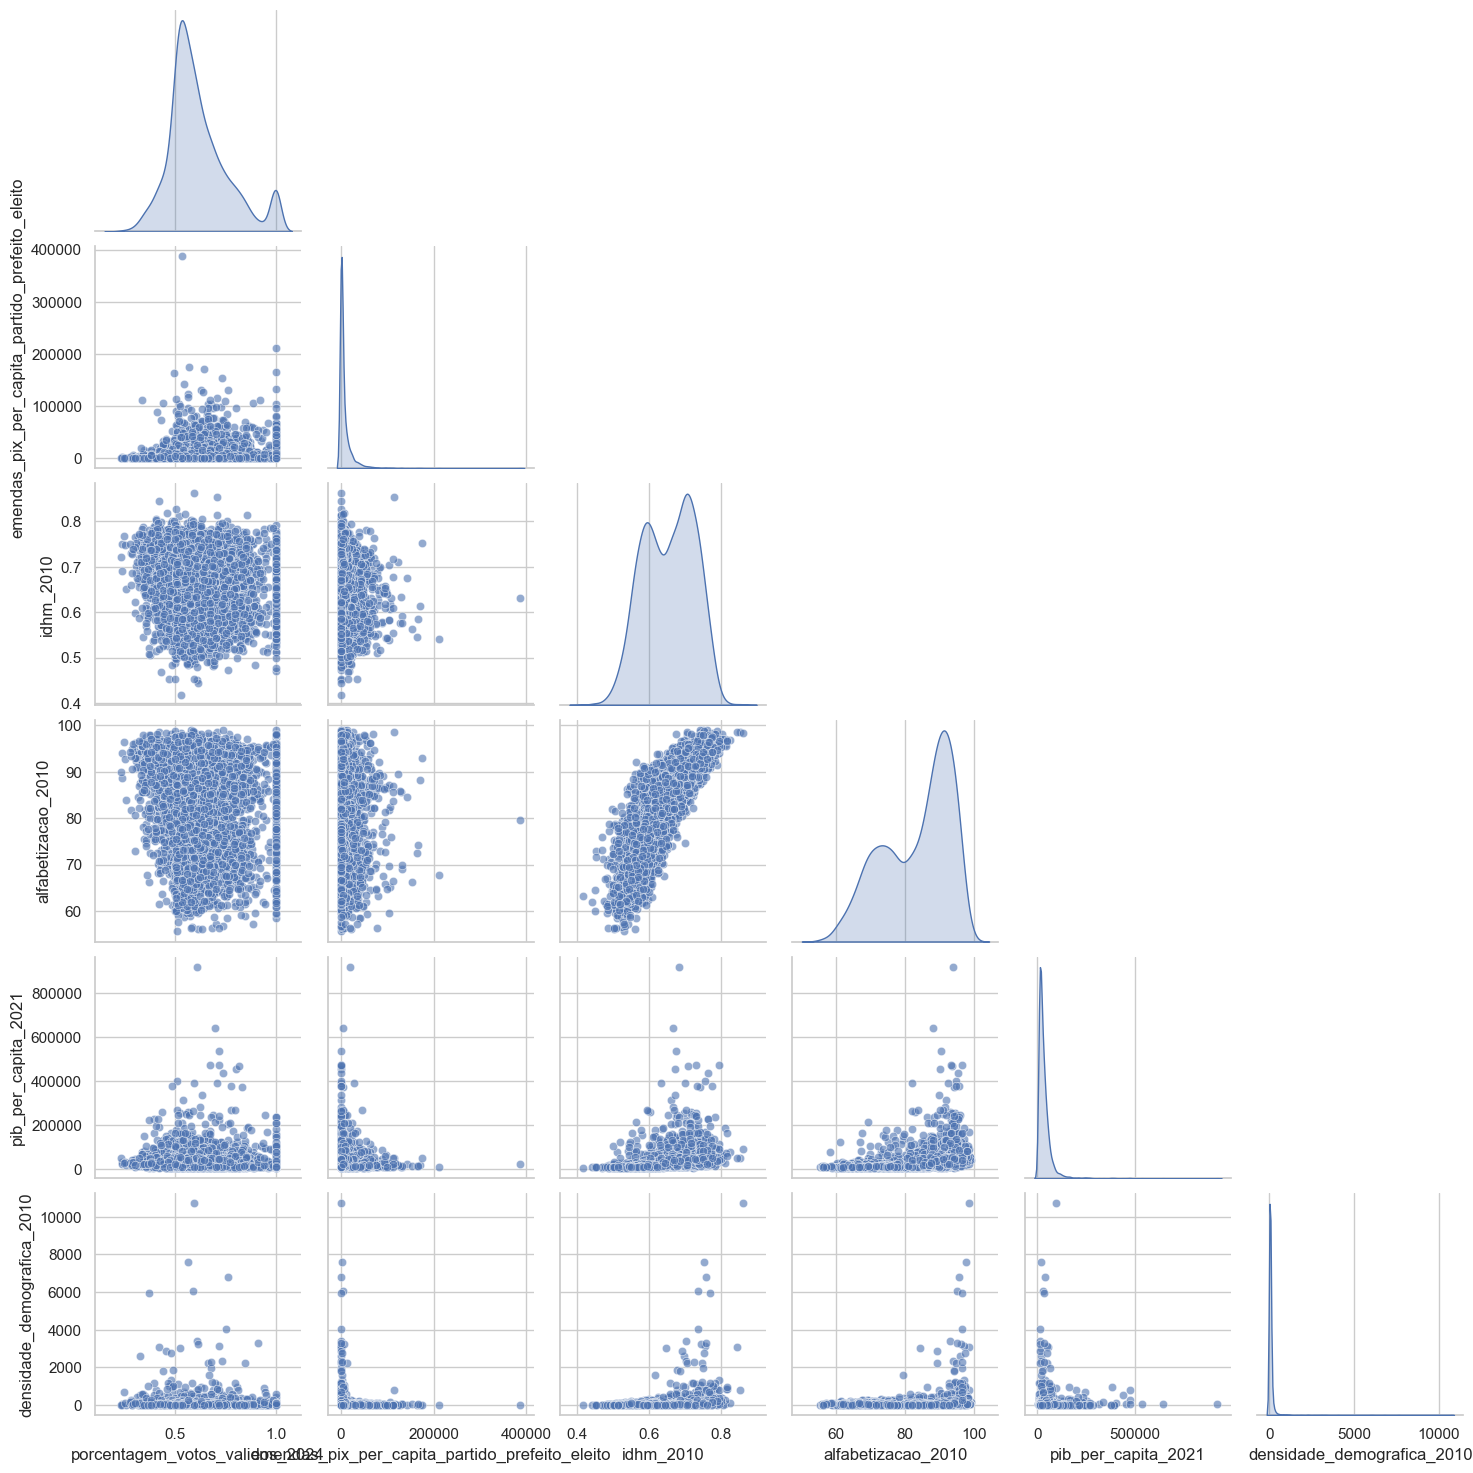

In [221]:
sns.pairplot(df[num_cols], corner=True, diag_kind='kde',
             height=2.5, plot_kws={'alpha':0.6})

## Boxplot de Emendas PIX por Partido

Distribuição do valor per capita das emendas entre os 10 partidos com mais municípios.

C:\Users\bruno\AppData\Local\Temp\ipykernel_7140\154977831.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['sigla_partido_prefeito_eleito'].isin(top_parties)],


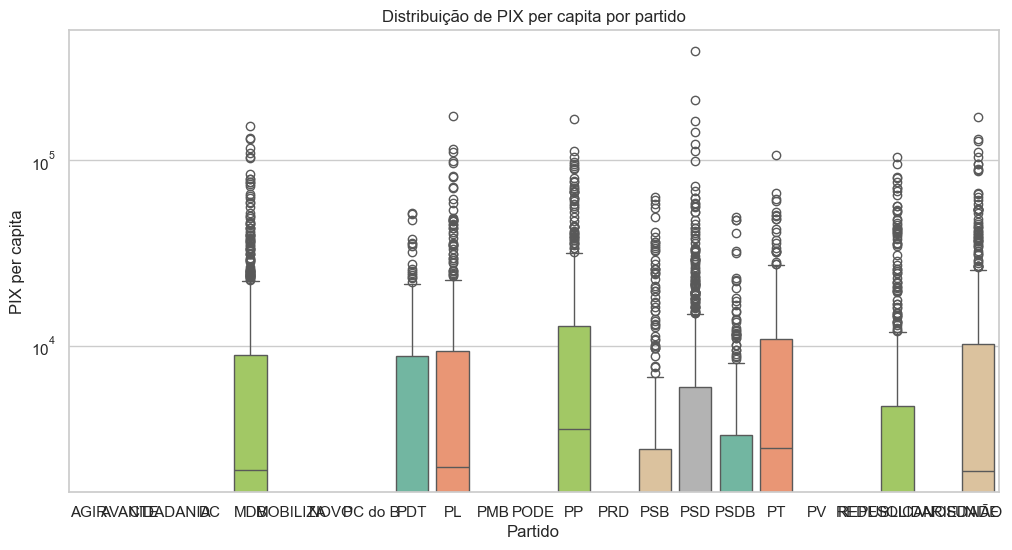

In [222]:
top_parties = party_counts.index[:10]
plt.figure(figsize=(12,6))
sns.boxplot(data=df[df['sigla_partido_prefeito_eleito'].isin(top_parties)],
            x='sigla_partido_prefeito_eleito',
            y='emendas_pix_per_capita_partido_prefeito_eleito',
            palette='Set2')
plt.yscale('log')
plt.xlabel('Partido')
plt.ylabel('PIX per capita')
plt.title('Distribuição de PIX per capita por partido')
plt.show()

## Relação entre Emendas PIX per capita e Desempenho Eleitoral

Verificamos se há correlação entre o valor das emendas recebidas e a proporção de votos válidos.

Total de municípios: 2698
Casos com 100% dos votos válidos: 166
Casos com soma de emendas PIX igual a 0: 0


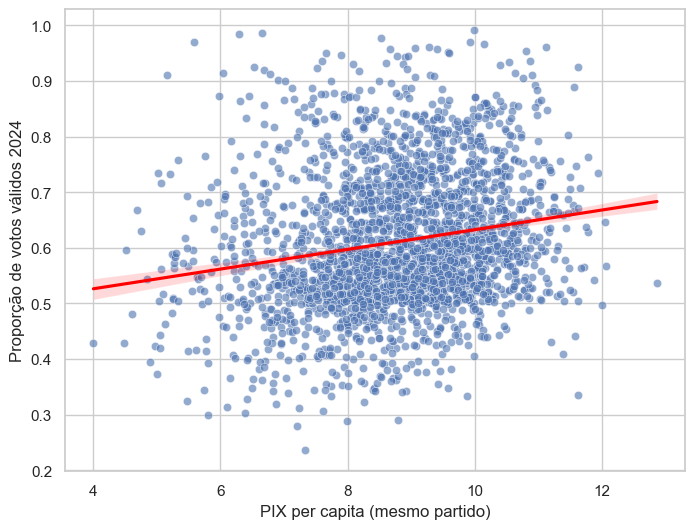

In [223]:
# # Primeiro, retirar os valores 0 de emendas_pix_per_capita_partido_prefeito_eleito
df = df[df['emendas_pix_per_capita_partido_prefeito_eleito'] > 0]
# Contagem de casos removidos
total = len(df)
count_100 = (df['porcentagem_votos_validos_2024'] >= 1).sum()
count_zero = (df['emendas_pix_per_capita_partido_prefeito_eleito'] == 0).sum()
print(f'Total de municípios: {total}')
print(f'Casos com 100% dos votos válidos: {count_100}')
print(f'Casos com soma de emendas PIX igual a 0: {count_zero}')

# Filtrar dados para a análise
df = df[(df['emendas_pix_per_capita_partido_prefeito_eleito'] > 0) &
        (df['porcentagem_votos_validos_2024'] < 1)]

# Utilizar escala adequada para o gráfico
df['emendas_pix_per_capita_partido_prefeito_eleito'] = np.log1p(df['emendas_pix_per_capita_partido_prefeito_eleito'])

fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=df, x='emendas_pix_per_capita_partido_prefeito_eleito', y='porcentagem_votos_validos_2024', alpha=0.6, ax=ax)
sns.regplot(data=df, x='emendas_pix_per_capita_partido_prefeito_eleito', y='porcentagem_votos_validos_2024', scatter=False, color='red', ax=ax)
ax.set_xlabel('PIX per capita (mesmo partido)')
ax.set_ylabel('Proporção de votos válidos 2024')
plt.show()

## Correlações

Matriz de correlação entre as variáveis numéricas.

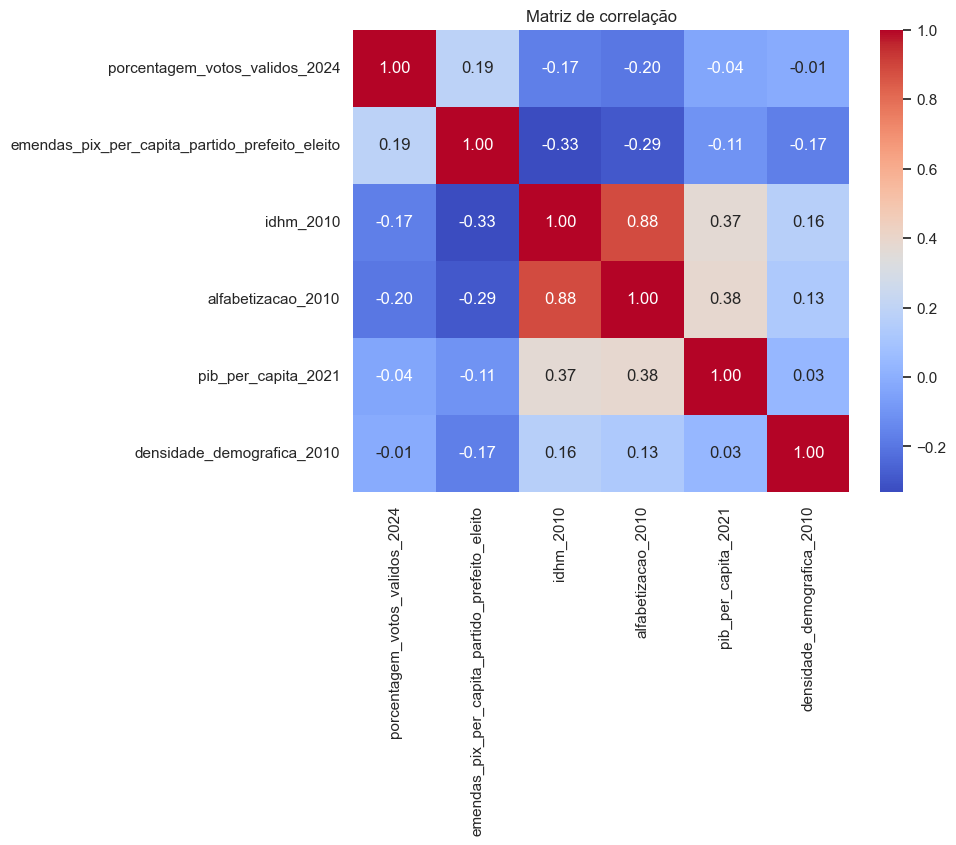

In [224]:
corr = df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de correlação')
plt.show()


# Relação entre Emendas PIX per capita e Desempenho Eleitoral por Partido

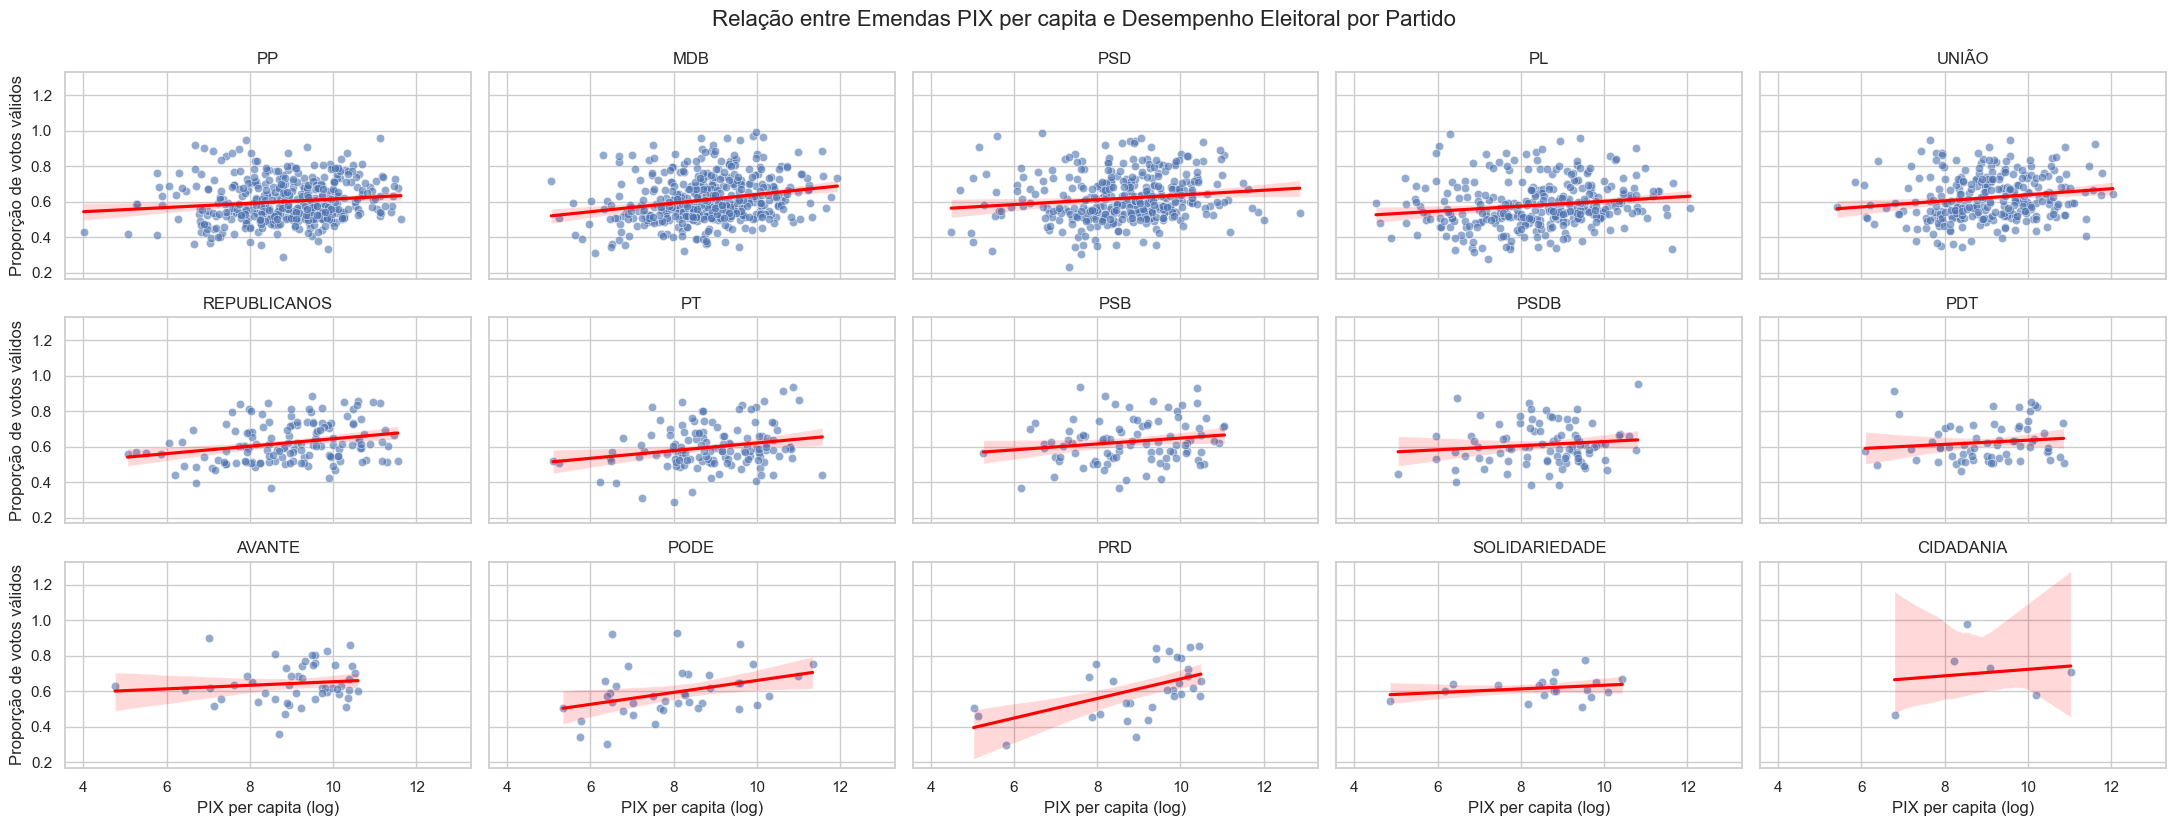

In [225]:
# Seleciona os 10 partidos com mais municípios
top_parties = df['sigla_partido_prefeito_eleito'].value_counts().index[:15]

fig, axes = plt.subplots(3, 5, figsize=(22, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, party in enumerate(top_parties):
    party_df = df[df['sigla_partido_prefeito_eleito'] == party]
    sns.scatterplot(
        data=party_df,
        x='emendas_pix_per_capita_partido_prefeito_eleito',
        y='porcentagem_votos_validos_2024',
        alpha=0.6,
        ax=axes[i]
    )
    sns.regplot(
        data=party_df,
        x='emendas_pix_per_capita_partido_prefeito_eleito',
        y='porcentagem_votos_validos_2024',
        scatter=False,
        color='red',
        ax=axes[i]
    )
    axes[i].set_title(party)
    axes[i].set_xlabel('PIX per capita (log)')
    axes[i].set_ylabel('Proporção de votos válidos')

plt.tight_layout()
plt.suptitle('Relação entre Emendas PIX per capita e Desempenho Eleitoral por Partido', y=1.03, fontsize=16)
plt.show()